THIS FILE'S MAIN OBJECTIVE WAS TO EXPERIMENT WITH 3D CNN PERFORMANCE AND SELECT BEST PARAMETERS USING RANDOM SEARCH

In [ ]:
# req libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# tensorFlow and keras lib

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

#setting random seed to avoid randomness after re rerunning code
import random

os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline


In [ ]:
# resizing , batch size
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32


# dataset directory and classes for classification
dataset_directory = 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'  # Update with the correct path if necessary
classes = ['Cyst', 'Normal', 'Stone', 'Tumor']


In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Create directories for train, validation, and test sets
base_dir = 'kidney_split_dataset'

if not os.path.exists(base_dir):
    os.makedirs(base_dir)
    os.makedirs(os.path.join(base_dir, 'train'))
    os.makedirs(os.path.join(base_dir, 'validation'))
    os.makedirs(os.path.join(base_dir, 'test'))


    for subset in ['train', 'validation', 'test']:
        for class_name in classes:
            os.makedirs(os.path.join(base_dir, subset, class_name))



    # data split into train val , test
    for class_name in classes:
        class_dir = os.path.join(dataset_directory, class_name)
        images = os.listdir(class_dir)
        train_val_images, test_images = train_test_split(images, test_size=0.1, random_state=42)
        train_images, val_images = train_test_split(train_val_images, test_size=0.1111, random_state=42)  # Approx. 10% for validation

        # training imgs
        for img in train_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'train', class_name, img)
            shutil.copyfile(src, dst)

        # validation imgs
        for img in val_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'validation', class_name, img)
            shutil.copyfile(src, dst)

        # test imgs
        for img in test_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(base_dir, 'test', class_name, img)
            shutil.copyfile(src, dst)


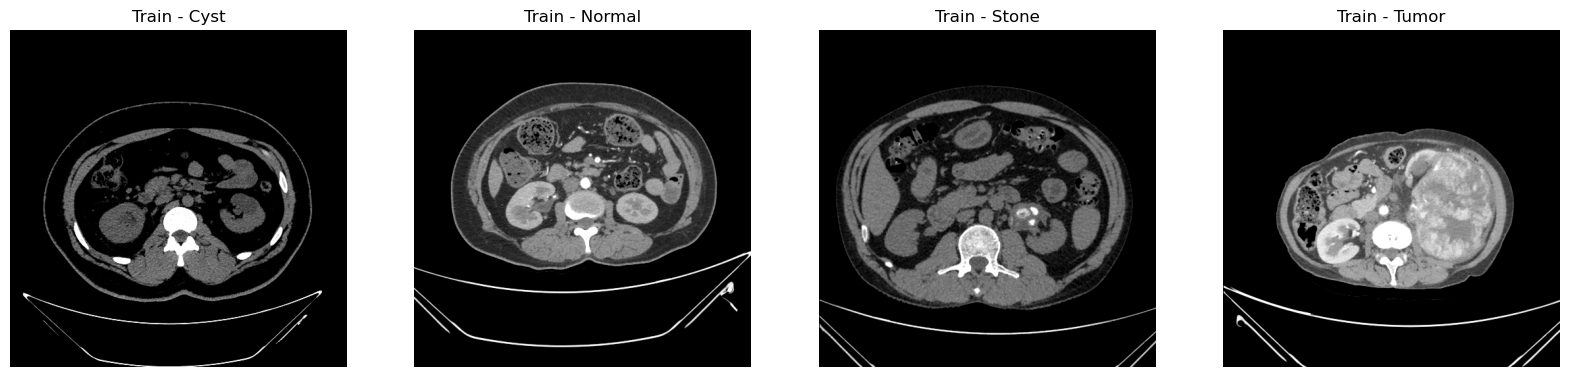

In [38]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def visualize_samples(directory, subset='train'):
    fig, axes = plt.subplots(nrows=1, ncols=len(classes), figsize=(20, 5))

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, subset, class_name)
        img_list = os.listdir(class_dir)
        img_name = random.choice(img_list)
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'{subset.capitalize()} - {class_name}')
        axes[i].axis('off')

    plt.show()

visualize_samples(base_dir, 'train')


In [ ]:
def preprocess_image(image):
    
    # Resize , normalize
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    return image


def preprocess_sequence(image_paths):
    
    images = [preprocess_image(tf.image.decode_jpeg(tf.io.read_file(img))) for img in image_paths]
    return tf.stack(images, axis=0)  


In [40]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])



In [41]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
validation_generator = validation_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'validation'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False,
    seed=42
)


Found 9954 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.
Found 1246 images belonging to 4 classes.


In [42]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
from tensorflow.keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, Dense, Dropout
from tensorflow.keras import Input, Model

def build_model(filters=32, dropout_rate=0.5):
    inputs = Input(shape=(3, IMG_HEIGHT, IMG_WIDTH, 1))

    # 3D Convolutional layers layout with varying parameters

    x = Conv3D(filters, kernel_size=(3, 3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(x)

    x = Conv3D(filters * 2, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(x)

    x = Conv3D(filters * 4, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(x)

    # global avergepooling of all layers, with dense layer and variable drop rate
    
    x = GlobalAveragePooling3D()(x)

    x = Dense(1024, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    # output-layer
    outputs = Dense(len(classes), activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [ ]:
from sklearn.model_selection import ParameterSampler
from tensorflow.keras.callbacks import EarlyStopping

# grid cominations set for random search

param_grid = {
    'filters': [32, 64],
    'dropout_rate': [0.3, 0.5],
    'batch_size': [16, 32]
}

# no of combinations tried is 5
n_iter = 5  
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))

best_model = None
best_val_accuracy = 0
best_params = None


for idx, params in enumerate(param_list):
    
    print(f"\n*** Hyperparameter Set {idx+1}/{n_iter}: {params} ***")
    
    
    model = build_model(filters=params['filters'], dropout_rate=params['dropout_rate'])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    train_generator.batch_size = params['batch_size']
    validation_generator.batch_size = params['batch_size']
    

    # early stopping function incase of overfitting
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    # trains the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=20,  
        class_weight=class_weights_dict,
        callbacks=[early_stopping]
    )

    # best accuracy of each repective model
    val_accuracy = max(history.history['val_accuracy'])
    print(f"Best Validation Accuracy for this set: {val_accuracy}")

    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model
        best_params = params

print("\n*** Hyperparameter Search Complete ***")
print(f"Best Validation Accuracy: {best_val_accuracy}")
print(f"Best Hyperparameters: {best_params}")



*** Hyperparameter Set 1/5: {'filters': 64, 'dropout_rate': 0.3, 'batch_size': 16} ***
Epoch 1/20
623/623 [==============================] - 347s 547ms/step - loss: 1.1795 - accuracy: 0.5376 - val_loss: 0.9902 - val_accuracy: 0.6621
Epoch 2/20
623/623 [==============================] - 341s 547ms/step - loss: 1.0633 - accuracy: 0.6454 - val_loss: 0.9534 - val_accuracy: 0.6485
Epoch 3/20
623/623 [==============================] - 344s 552ms/step - loss: 1.0307 - accuracy: 0.6461 - val_loss: 0.9438 - val_accuracy: 0.6501
Epoch 4/20
623/623 [==============================] - 340s 545ms/step - loss: 0.9951 - accuracy: 0.6547 - val_loss: 0.8630 - val_accuracy: 0.6790
Epoch 5/20
623/623 [==============================] - 338s 542ms/step - loss: 0.9506 - accuracy: 0.6697 - val_loss: 0.9041 - val_accuracy: 0.6204
Epoch 6/20
623/623 [==============================] - 337s 542ms/step - loss: 0.8800 - accuracy: 0.6901 - val_loss: 0.7267 - val_accuracy: 0.7352
Epoch 7/20
623/623 [================

Conclusion drawn from results in order to set parameters for 3D cnn training:

Best Validation Accuracy: 0.9582664370536804
Best Hyperparameters: {'filters': 64, 'dropout_rate': 0.3, 'batch_size': 16}

The architecure has a layout of 3D CNN layers followed by a pooling layer each
so from results drawn they will be 64, 128, 256

